# The Simplified Resonate-and-Fire Neuron: Part II

### Tutorial by Giorgie I. Goiati
Special thanks to Corentin Houpert for the maths help

# Introduction
In this tutorial, you will:
* Simplify the RF neuron model to a more practical form for neural network applications.
  * In essence, we mimic the approach done for LIF neurons in "Training Spiking Neural Networks Using Lessons From Deep Learning" ([Eshraghian et al., 2023](https://ieeexplore.ieee.org/document/10242251)).

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from plotter import snn_plot, plot_phase_portrait

In [2]:
# Simulation constants
NUM_STEPS = 500
DT = 0.01

# 1. Simplifying the Resonate-and-Fire Neuron Model

In the previous tutorial, we dove into the "basic" Resonate-and-Fire (RF) neuron model. But it turned out to be far from basic, featuring an array of hyperparameters to tune, including $b$, $\omega$, $\Delta t$, $\vartheta$, and the wide array of reset and refractory mechanisms. Moreover, noticable numerical errors surfaced during simulations, which hindered the model's performance.  
So, just like with the LIF neuron, we can make a few simplifications to the RF neuron model.

## 1.1 The Decay Rate and Rotation Factor: $\beta$ \& $\rho$
Recall the following solution to the RF neuron model derived using the forward Euler method:
$$ U(t + \Delta t) = (1 - b \Delta t + i\omega \Delta t)U(t) + \Delta t I(t) \tag{1}$$
Now assume no input current, $I(t) = 0$:
$$ U(t + \Delta t) = (1 - b \Delta t + i\omega \Delta t)U(t)$$

As with the LIF neuron, let's define a constant describing the change between subsequent values of $U$. Unlike the LIF neuron, this isn't just the decay rate (the inverse time constant) – it needs to encapsulate the oscillation as well – so let's call this complex-valued update factor $\gamma$ instead:

$$\gamma := \frac{U(t + \Delta t)}{U(t)} \implies U(t + \Delta t) = \gamma U(t) \tag{2}$$

From (1), this implies:

$$ \gamma = 1 - b \Delta t + i\omega \Delta t. \tag{3}$$

We can separate this multiplier into two distinct factors, $\gamma = \beta \cdot \rho$ :
- $\beta = 1 - b \Delta t$ – the *decay rate*, which describes how much the membrane potential decays per time step.
- $\rho = 1 + i \omega \Delta t$ – the *rotation factor*, which accounts for the oscillatory contribution.

These factors are first-order approximations, and while $\beta$ remains relatively stable, the same can't be said about $\rho$, which is more sensitive to discretisation error due to its oscillatory dynamics.

Instead, we can identify the exact form of these factors by using the continuous time-dependent form of the solution, derived in the previous tutorial:
$$ U(t) = U(0) e^{(-b + i\omega)t} = U(0) e^{-bt} e^{i \omega t} \tag{4}$$

If we assume (4) is computed at discrete steps of $t, (t + \Delta t), (t+2\Delta t) ...$, then we can calculate the ratio of membrane potential across two subsequent steps:
$$ \begin{align*}
&\gamma = \frac{U(0) e^{(-b + i\omega)(t + \Delta t)}}{U(0) e^{(-b + i\omega)t}} = \frac{U(0) e^{(-b + i\omega)(t + 2 \Delta t)}}{U(0) e^{(-b + i\omega)(t + \Delta t)}} = \cdots \\ 
&\implies \gamma = e^{(-b + i\omega)\Delta t} = e^{-b\Delta t} e^{i\omega\Delta t}
\end{align*} $$

We then separate $\gamma$ to arrive at
$$ \begin{align*}
\gamma &= \beta \cdot \rho \\
\implies &\begin{cases}
    \beta = e^{-b\Delta t} \\
    \rho = e^{i\omega\Delta t}
\end{cases} \tag{5}
\end{align*} $$

In practice, $\beta$ remains a hard-coded (learnable) parameter, as in the LIF neuron – $\rho$ on the other hand is pre-computed via $\rho = e^{i\omega\Delta t}$.
This gives us the following update rule for $U(t)$:
$$ U(t + \Delta t) = \beta \cdot \overbrace{e^{i\omega\Delta t}}^{\rho} \cdot U(t) + \Delta t I(t) \tag{6} $$

> **Note**: $\rho$ and $\omega$ are static hyperparameters in this formulation. We're still investigating whether it is worth making them trainable or not (which would involve notable computational overhead from having to recompute an exponential at each time step).

### Investigating the Euler Error and Relation Between Parameters

To better understand how these factors relate to the previous formulation, let's run some simulations.  
First, let's investigate how the choice of parameters affects the Euler error.

omegas: [0.05 0.1  0.2 ], rhos: [0.999+0.05j  0.995+0.1j   0.98 +0.199j]
bs: 0.01, beta: 0.99


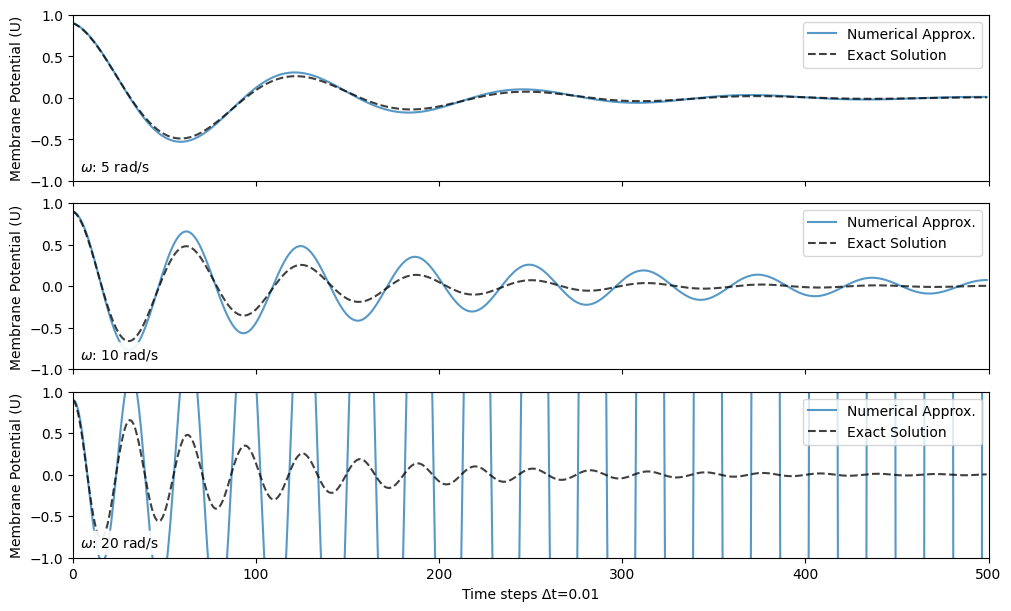

In [25]:
omegas = np.array([5, 10, 20])
omegas_scaled = omegas * DT
rhos = np.exp(1j * omegas_scaled)
b = 1 * DT
beta = np.exp(-b)
print(f"omegas: {omegas_scaled}, rhos: {rhos.round(3)}\nbs: {b}, beta: {beta:<.2f}")

mem, mem_exact = np.full_like(omegas, 0.9 + 0j, dtype=complex), np.full_like(omegas, 0.9 + 0j, dtype=complex)
mem_rec, mem_exact_rec = np.zeros((len(omegas), NUM_STEPS), dtype=complex), np.zeros((len(omegas), NUM_STEPS), dtype=complex)

for step in range(NUM_STEPS):
    mem_rec[:, step] = mem
    mem = mem + (-b + 1j * omegas_scaled) * mem # forward Euler method
    mem_exact_rec[:, step] = mem_exact
    mem_exact = beta * rhos * mem_exact # new exact method

fig, axs = plt.subplots(len(omegas), 1, figsize=(10, 6), layout='constrained', sharex=True, sharey=True, squeeze=False)
axs = axs.flatten()
for i in range(len(omegas)):
    axs[i].plot(mem_rec[i].real, label="Numerical Approx.", c='tab:blue', alpha=0.75)
    axs[i].plot(mem_exact_rec[i].real, label="Exact Solution", linestyle='--', c='black', alpha=0.75)
    axs[i].annotate(f"$\\omega$ = {omegas[i]} rad/s", xy=(0, 0), xycoords='axes fraction', xytext=(+0.5, +0.5),
                   textcoords='offset fontsize', fontsize='medium', verticalalignment='bottom', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=.9, edgecolor="none"))
    axs[i].set_ylabel("Membrane Potential (U)")
    axs[i].legend(loc='upper right')
plt.xlabel(f"Time steps \u0394t={DT}")
plt.xlim([0, NUM_STEPS])
plt.ylim([-1, 1])
plt.show()

We can see as $\omega$ increases, the error in the numerical approximation also increases.  
Moreover, the Euler formulation sets a limit on the stability of the simulation of $\omega < \frac{1}{\Delta t}$.  
And even moreover, is the fact that the exact solution remains stable regardless of the decay parameter, whereas for the numerical solution, $b$ is limited by $\omega$, since $(1 - b\Delta t + \omega \Delta t)$ must be $\leq 1$ to stay stable.

We can run it again with a lower $\Delta t$ to see how it affects the stability and accuracy of the numerical solution.

omegas: [0.005 0.01  0.02 ], rhos: [1.+0.005j 1.+0.01j  1.+0.02j ]
bs: 0.001, betas: 0.999


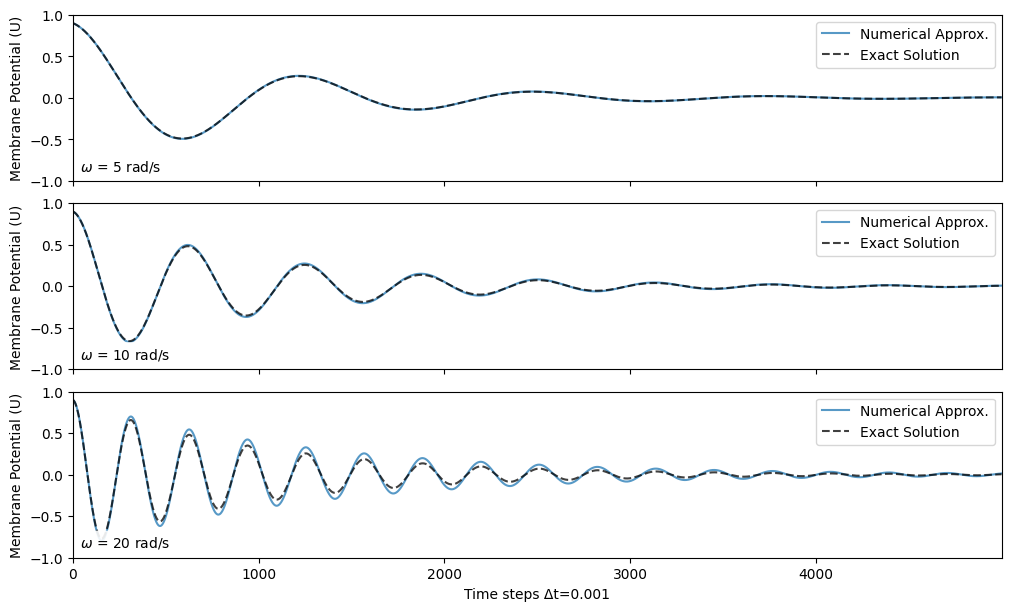

In [27]:
scaling_factor = 0.1
dt, num_steps = DT * scaling_factor, int(NUM_STEPS // scaling_factor)
omegas = np.array([5, 10, 20])
omegas_scaled = omegas * dt
rhos = np.exp(1j * omegas_scaled)
b = 1 * dt
beta = np.exp(-b)
print(f"omegas: {omegas_scaled}, rhos: {rhos.round(3)}\nbs: {b}, betas: {beta.round(3)}")

mem, mem_exact = np.full_like(omegas, 0.9 + 0j, dtype=complex), np.full_like(omegas, 0.9 + 0j, dtype=complex)
mem_rec, mem_exact_rec = np.zeros((len(omegas), num_steps), dtype=complex), np.zeros((len(omegas), num_steps), dtype=complex)

for step in range(num_steps):
    mem_rec[:, step] = mem
    mem = mem + (-b + 1j * omegas_scaled) * mem # forward Euler method
    mem_exact_rec[:, step] = mem_exact
    mem_exact = beta * rhos * mem_exact # new exact method

fig, axs = plt.subplots(3, 1, figsize=(10, 6), layout='constrained', sharex=True, sharey=True)
for i in range(len(omegas)):
    axs[i].plot(mem_rec[i].real, label="Numerical Approx.", c='tab:blue', alpha=0.75)
    axs[i].plot(mem_exact_rec[i].real, label="Exact Solution", linestyle='--', c='black', alpha=0.75)
    axs[i].annotate(f"$\\omega$ = {omegas[i]} rad/s", xy=(0, 0), xycoords='axes fraction', xytext=(+0.5, +0.5),
                   textcoords='offset fontsize', fontsize='medium', verticalalignment='bottom', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=.9, edgecolor="none"))
    axs[i].set_ylabel("Membrane Potential (U)")
    axs[i].legend(loc='upper right')
plt.xlabel(f"Time steps \u0394t={dt}")
plt.xlim([0, num_steps])
plt.ylim([-1, 1])
plt.show()

Much better! But we did just multiply the amount of calculations done by 10, which can't always be a possibility.  
Fortunately, the exact method tends to be just as computationally efficient as the numerical method (as the next section tests), allowing us to maintain the more accurate formulation.

### Benchmark: Comparison of RF Formulations

The more exact formulation of the RF neuron (6) is naturally more accurate and stable, but are there any downsides?

Well, the only possible downside would be that it is more complex and computationally intensive, so let's figure out to what extent this matters in practice.
For this benchmark, we test the following two implementations:

1. **Forward Euler method**: $U[t + \Delta t] = (1 - b + i \omega) U[t] + I[t]$
2. **Exact discretized form**: $U[t + \Delta t] = \beta \rho U[t] + I[t]$, where $\rho = e^{i \omega}$

We're assuming $b$, $\beta$, and $\omega$ are all pre-scaled by $\Delta t$ to further simplify the computations (so $\Delta t = 1$).

We'll compare these in three different contexts:
- **Context 1**: No trainable parameters (multiplication factor can be precomputed)
- **Context 2**: Only $b/\beta$ is trainable (frequency terms can be precomputed)  
- **Context 3**: Both $b/\beta$ and $\omega$ are trainable (full recomputation needed)

In [30]:
# Setup implementations
class ForwardEulerRF(nn.Module):
    def __init__(self, b, omega, learn_b=False, learn_omega=False):
        super().__init__()
        # Register parameters or simple tensors (would be buffers in practice)
        self.b = nn.Parameter(torch.tensor(b, dtype=torch.float32)) if learn_b else torch.tensor(b, dtype=torch.float32)
        self.omega = nn.Parameter(torch.tensor(omega, dtype=torch.float32)) if learn_omega else torch.tensor(omega, dtype=torch.float32)
        # Precompute if both parameters are fixed
        if not (learn_b or learn_omega):
            self.register_buffer('mult_factor', torch.complex(1 - self.b, self.omega))
    
    def forward(self, input_current, membrane_potential):
        if hasattr(self, 'mult_factor'):
            mult_factor = self.mult_factor
        else:
            mult_factor = torch.complex(1 - self.b, self.omega)
        return mult_factor * membrane_potential + input_current

class ExactDiscretizedRF(nn.Module):    
    def __init__(self, beta, omega, learn_beta=False, learn_omega=False):
        super().__init__()
        # Register parameters or simple tensors (would be buffers in practice)
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32)) if learn_beta else torch.tensor(beta, dtype=torch.float32)
        self.omega = nn.Parameter(torch.tensor(omega, dtype=torch.float32)) if learn_omega else torch.tensor(omega, dtype=torch.float32)
        # Precompute based on trainable parameters
        if not learn_beta and not learn_omega:
            self.register_buffer('mult_factor', self.beta * torch.exp(1j * self.omega))
        elif not learn_omega:
            self.register_buffer('rho', torch.exp(1j * self.omega))
    
    def forward(self, input_current, membrane_potential):
        if hasattr(self, 'mult_factor'):        # Context 1: Fully precomputed
            mult_factor = self.mult_factor
        elif hasattr(self, 'rho'):             # Context 2: Only rho precomputed
            mult_factor = self.beta * self.rho
        else:                                  # Context 3: Full computation
            mult_factor = self.beta * torch.exp(1j * self.omega)
        return mult_factor * membrane_potential + input_current

Running RF Formulation Benchmark...


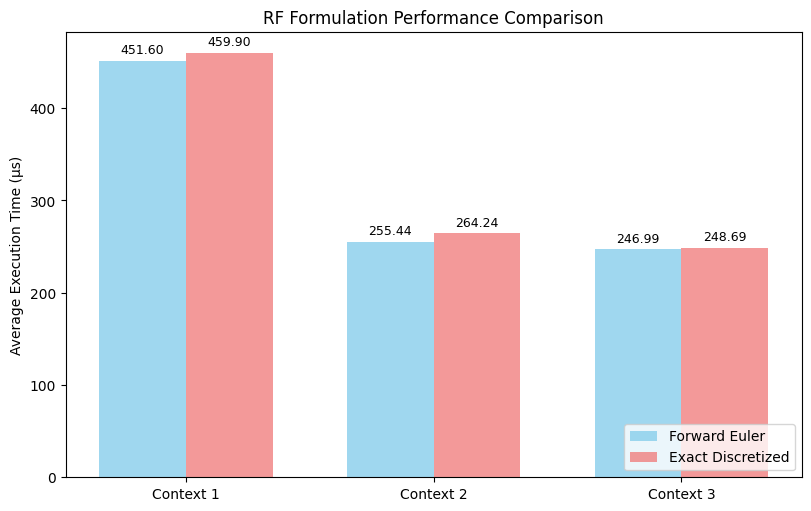

In [96]:
# Run benchmark
from time import perf_counter
def single_rf_benchmark(model, input_current, initial_mem, num_steps, warmup_iterations=100):
    model.eval()
    # Warmup
    mem = initial_mem.clone()
    for _ in range(warmup_iterations):
        mem = model(input_current, mem)
    # Actual timing
    start_time = perf_counter()
    mem = initial_mem.clone()
    for _ in range(num_steps):
        mem = model(input_current, mem)
    return perf_counter() - start_time

dt, num_steps = DT * 0.5, int(NUM_STEPS / 0.5)
batch_size, num_neurons = 256, 1024
# RF Neuron parameters
b = 1 * dt                      # Forward Euler decay rate
beta = np.exp(-b)               # Exact discretized decay factor
omegas = np.array([5, 10, 20]) * dt       # Frequencies for both

contexts = [
    ('Context 1: No trainable params', False, False),
    ('Context 2: b/beta trainable', True, False), 
    ('Context 3: Both trainable', True, True)
]

print("Running RF Formulation Benchmark...")
fe_avg, ed_avg = [], []
for context_name, learn_decay, learn_omega in contexts:
    fe_res, ed_res = [], []
    for omega in omegas:
        input_current = torch.randn(batch_size, num_neurons, dtype=torch.float32) * dt
        initial_mem = torch.randn(batch_size, num_neurons, dtype=torch.cfloat)
        
        fe_model = ForwardEulerRF(b, omega, learn_decay, learn_omega)
        fe_res.append(single_rf_benchmark(fe_model, input_current, initial_mem, num_steps) / num_steps)

        ed_model = ExactDiscretizedRF(beta, omega, learn_decay, learn_omega)
        ed_res.append(single_rf_benchmark(ed_model, input_current, initial_mem, num_steps) / num_steps)
    fe_avg.append(np.mean(fe_res) * 1e6) # Convert to microseconds
    ed_avg.append(np.mean(ed_res) * 1e6)

fig = plt.figure(figsize=(8, 5), layout='constrained')
x_pos = np.arange(len(contexts))
bars1 = plt.bar(x_pos - 0.35/2, fe_avg, 0.35, label='Forward Euler', alpha=0.8, color='skyblue')
bars2 = plt.bar(x_pos + 0.35/2, ed_avg, 0.35, label='Exact Discretized', alpha=0.8, color='lightcoral')
plt.ylabel('Average Execution Time (μs)')
plt.title('RF Formulation Performance Comparison')
plt.xticks(x_pos, [ctx[0].split(':')[0] for ctx in contexts])
plt.legend(loc='lower right')
# Add value labels on bars
for bars, times in zip([bars1, bars2], [fe_avg, ed_avg]):
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2., times[i] + 0.01*max(times),
                 f'{times[i]:.2f}', ha='center', va='bottom', fontsize=9)
plt.show()

Turns out the exact RF neuron definition is roughly as simple to run as the forward Euler one!  
With this in mind, we'll continue with the exact formulation (6).

## 1.2 Discrete Time Steps \& Weighted Input
Instead of assuming $t$ to represent continuous time, we can discretise $t$ into sequential time steps, i.e. $t_n = n\Delta t$ with $\Delta t = 1$.
This takes $\Delta t$ out of the equation for $U(t)$, but it does not mean we can fully ignore it either, as it is needed to appropriately set the $\omega$ and $\beta$ parameters.

**In continuous time:**
- $\omega$: oscillation frequency in *radians per second* (rad/s)
- $\beta$: decay rate as the *remaining fraction of $U$ per second*
  - This is where we depart from the LIF model, where $\beta$ is a simple per step value. In order to maintain the same time-dependent dynamics, $\beta$ must match the per second time scale of $\omega$.  
    This follows from (5), where $\beta = e^{-b\Delta t}$, with $b$ being a per second value.

**In discrete time:**
- $\omega_{\rm step} = \omega \Delta t$: oscillation frequency in *radians per time step* (rad/step)
- $\beta_{\rm step} = \beta^{\Delta t}$: decay rate as the *remaining fraction of $U$ per time step*
  - E.g., for an 4Hz signal sampled at $\Delta t = 0.01$, the corresponding resonant frequency is $\omega_{\rm step} = 4 \cdot 2\pi \cdot \Delta t \approx 0.251$ rad/step

***

Next, moving further away from physical plausibility as with the LIF model, we shift the input by one step to instantaneously contribute to the input current, which more closely resembles an RNN.
Similarly, the input current is scaled by a trainable weight instead of $\Delta t$, i.e., $\Delta t I[t] = W X[t + 1]$, which leads to the following:

$$ \begin{align*} 
U[t + 1] &= \beta \rho U[t] + W X[t+1], \\
\text{where } &\beta = \beta^{\Delta t} \text{ and } \rho = e^{i \omega \Delta t}. \tag{7}
\end{align*}$$

## 1.3 Spiking & Reset Mechanisms
Let's account for the spiking and reset mechanisms.  

The spike condition remains simple, which is whenever the imaginary or real part of the membrane potential exceeds a threshold $\vartheta$:
$$ S[t] = \begin{cases}
1, & \text{if } \Im(U[t]) > \vartheta \text{ or } \Re(U[t]) > \vartheta, \\
0, & \text{otherwise}.
\end{cases} \tag{8} $$

To promote sparsity, we have to apply some reset mechanism, which entails reducing the value of $U[t]$ after a spike.  
Since $U[t]$ is complex-valued, we can reset the real and imaginary parts independently – we define the following options:
$$\begin{align*}
    R[t] &= 
    \begin{cases}
        U[t], & \text{hard reset},\\
        \Re(U[t]), & \text{hard reset (real)},\\
        \Im(U[t]), & \text{hard reset (imag)},\\
        U[t] - i\vartheta,& \text{Izhikevich reset},\\
        U[t] - \vartheta,& \text{Izhikevich reset (inverted)},\\
        \text{sgn}(U[t])\cdot\vartheta\cdot\beta, & \text{soft reset},\\
        \text{sgn}(\Re(U[t]))\cdot\vartheta\cdot\beta, & \text{soft reset (real)},\\
        \text{sgn}(\Im(U[t]))\cdot i \vartheta\cdot\beta, & \text{soft reset (imag)},\\
        0, & \text{no reset (default),}
    \end{cases}
\end{align*} \tag{9} $$
with 
$$
\text{sgn}(x) = \begin{cases}
\frac{x}{|x|}, & \text{if } x \neq 0,\\
0, & \text{if } x = 0.
\end{cases}
$$

In [131]:
def resonate_and_fire(U, beta, rho, I=0, threshold=1, reset='none', spike_on='imag'):
    if spike_on == 'imag':
        spk = U.imag > threshold  # check if imaginary part exceeds threshold
    elif spike_on == 'real':
        spk = U.real > threshold  # check if real part exceeds threshold
    U = U * beta * rho + I

    match reset:
        case 'zero':
            U = U - spk * U  # hard reset to 0 + 0j
        case 'zero_real':
            U = U - spk * U.real  # reset real part to 0
        case 'zero_imag':
            U = U - spk * U.imag * 1j  # reset imaginary part to 0  
        case 'izhikevich':
            U = U - spk * (U - 1j * threshold)  # reset to 0 + 1j * threshold
        case 'izhikevich_real':
            U = U - spk * (U - threshold)  # reset to threshold + 0j
        # Use of np.sign() ensures subtraction towards 0
        case 'subtract':
            U = U - spk * np.sign(U) * threshold  # subtracts the threshold from the *magnitude*
        case 'subtract_real':
            U = U - spk * np.sign(U.real) * threshold  # subtract the threshold from real part only
        case 'subtract_imag':
            U = U - spk * 1j * np.sign(U.imag) * threshold  # subtract the threshold from imaginary part only
        case 'none':
            pass  # do nothing, keep U as is
    return spk, U

def generate_resonant_spikes(
        num_steps: int = NUM_STEPS,
        first_spike: int = None,
        dt: float = DT, 
        omega: float | int = 10, 
        n_spikes: int = 4,
        amplitude: int = 1, 
        add_neg_spike: bool = True, 
    ) -> np.ndarray:
    out = np.zeros(num_steps)
    if first_spike is None:
        first_spike = int(num_steps // 10)
    period = int(np.round((2 * np.pi) / omega / dt))
    end = first_spike + period * n_spikes
    if end > num_steps:
        end = num_steps
    for i in range(first_spike, end, period):
        out[i] = amplitude
    if add_neg_spike:
        out[i-period//2] = -amplitude
    return out

Number of spikes for each reset type:
  No Reset: 50
  Hard Reset: 2
  Zero Reset (Real): 30
  Zero Reset (Imag): 3
  Izhikevich Reset: 3
  Izhikevich Reset (Real): 3
  Subtract Reset: 3
  Subtract Reset (Real): 28
  Subtract Reset (Imag): 3


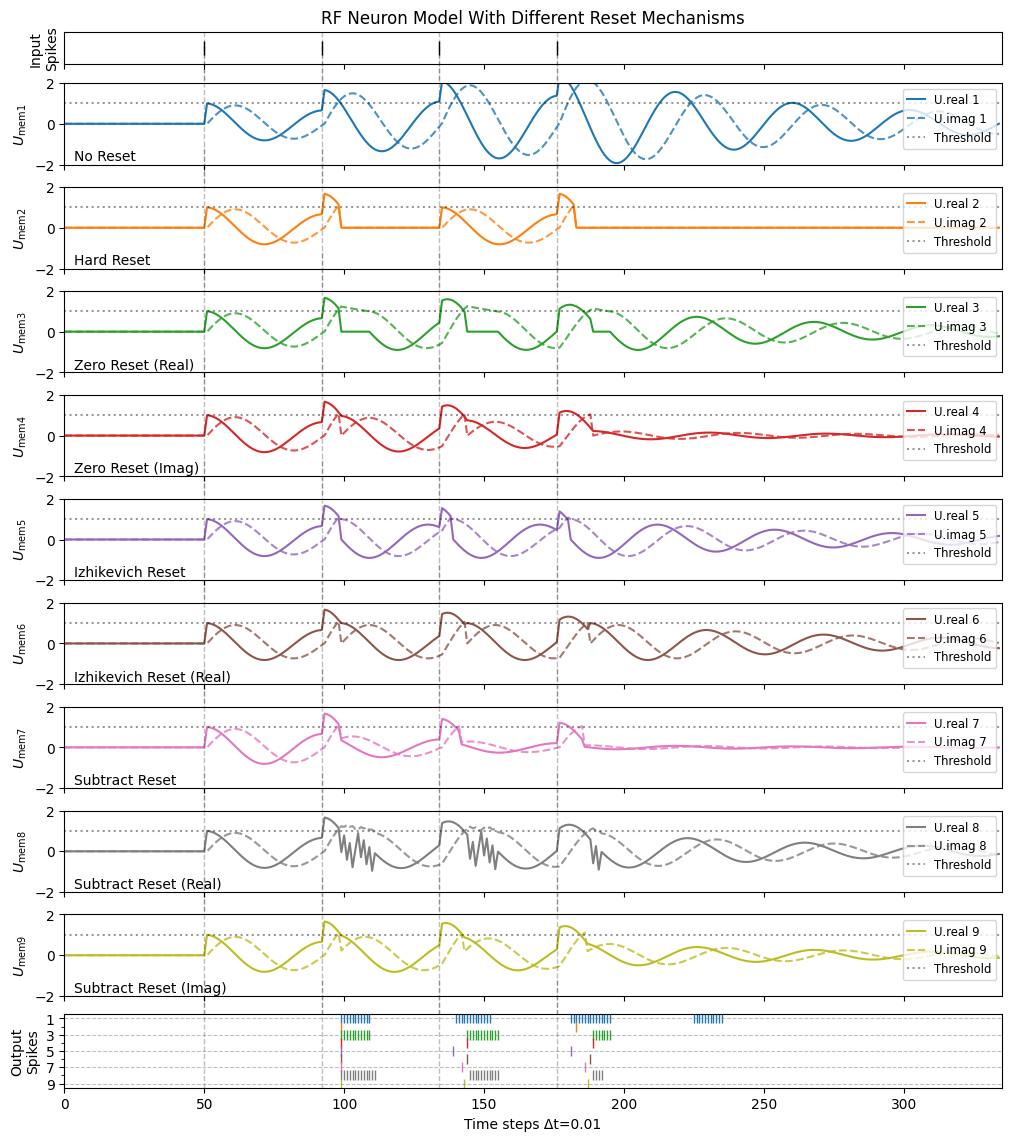

In [115]:
num_steps = int(NUM_STEPS*0.67)
beta, rho = np.exp(-1 * DT), np.exp(1j * 15 * DT)
amp_in = 1
spk_in = generate_resonant_spikes(num_steps, first_spike=50, omega=15., amplitude=amp_in, n_spikes=4, dt=DT, add_neg_spike=False)
threshold = 1.
# Test all reset types available
reset_types = ['none', 'zero', 'zero_real', 'zero_imag', 'izhikevich', 'izhikevich_real', 'subtract', 'subtract_real', 'subtract_imag']
reset_labels = ['No Reset', 'Hard Reset', 'Zero Reset (Real)', 'Zero Reset (Imag)', 'Izhikevich Reset', 'Izhikevich Reset (Real)', 'Subtract Reset', 'Subtract Reset (Real)', 'Subtract Reset (Imag)']

# Initialize variables for each reset type
n_resets = len(reset_types)
mem_vars = [(0 + 0j) for _ in range(n_resets)]
spk_vars = [False for _ in range(n_resets)]
mem_recs = [np.zeros(num_steps, dtype=complex) for _ in range(n_resets)]
spk_recs = [np.zeros(num_steps, dtype=bool) for _ in range(n_resets)]

for step in range(num_steps):
  for i in range(n_resets):
    mem_recs[i][step] = mem_vars[i]
    spk_recs[i][step] = spk_vars[i]
  for i, reset_type in enumerate(reset_types):
    spk_vars[i], mem_vars[i] = resonate_and_fire(mem_vars[i], beta, rho, spk_in[step], 
                                                           threshold=threshold, reset=reset_type, spike_on='imag')

# Print spike counts for each reset type
spike_counts = [spk_rec.sum() for spk_rec in spk_recs]
print("Number of spikes for each reset type:")
for reset_label, count in zip(reset_labels, spike_counts):
  print(f"  {reset_label}: {count}")

snn_plot(spk_in=spk_in, mem=mem_recs, spk_out=spk_recs, hline=threshold,
         ylim=2, fig_size=(10,1), vline=spk_in.nonzero()[0], dt=DT,
         title="RF Neuron Model With Different Reset Mechanisms",
         mem_labels=reset_labels)

In [100]:
a = plot_phase_portrait(mem_recs, spk_recs,
                    xylim=2, thrline=threshold, animate=True, dt=DT, animate_speed=.75,
                    mem_labels=reset_labels)
HTML(a.to_html5_video())

This is quite the array of options, and we aren't even considering refractory mechanisms on top of all these.
While ultimately dependent on the task specifics, we suggest sticking to `none`, `Izhikevich`, and `subtract` as the mechanisms that best retain the oscillatory dynamics – arguably some of the options we provide are just for completeness and impractical generally speaking.

## 1.4 Deriving a Firing Threshold
The threshold $\vartheta$ is set to 1 by default, which works well enough as long as the input current is scaled appropriately.
However, in the previous section we simplified $\Delta t$ away from the input and turned it into a *decoupled* trainable weight $W$. As a result, the unscaled input will quickly overwhelm the neuron when combined with the oscillations, and rise far above the threshold for small $\Delta t$, leading to excessive spiking.

Leaving $W$ as a trainable weight for simplicity, we instead scale the threshold $\vartheta$ to adjust spiking behaviour – which effectively has the same effect as scaling the input current.

From the previous tutorial, we know the maximum sustainable amplitude of the RF neuron for a resonant input current:
$$\begin{align*}
A_{\rm max} &= \frac{A_{\rm in} \sqrt{b^2 + \omega^2}}{b\sqrt{b^2 + 4\omega^2}}, \\
b &= - \ln(\beta), A_{\rm in} = 1. \\
\end{align*}$$

We can intuitively set a threshold proportional to this maximum amplitude:
$$\vartheta = \varepsilon \cdot A_{\rm max}$$

Additionally, we introduce a second scaling factor:
$$\vartheta = \varepsilon \cdot A_{\rm max} \cdot (1 - \beta^T), \tag{10}$$
where $T$ denotes the number of timesteps resonant input is expected for, with it scaling down $\vartheta$ to the achieved amplitude after $T$ steps.

Let's demonstrate this derived threshold how different choices of $\beta$ and $\omega$ affect the spiking behaviour of the RF neuron.

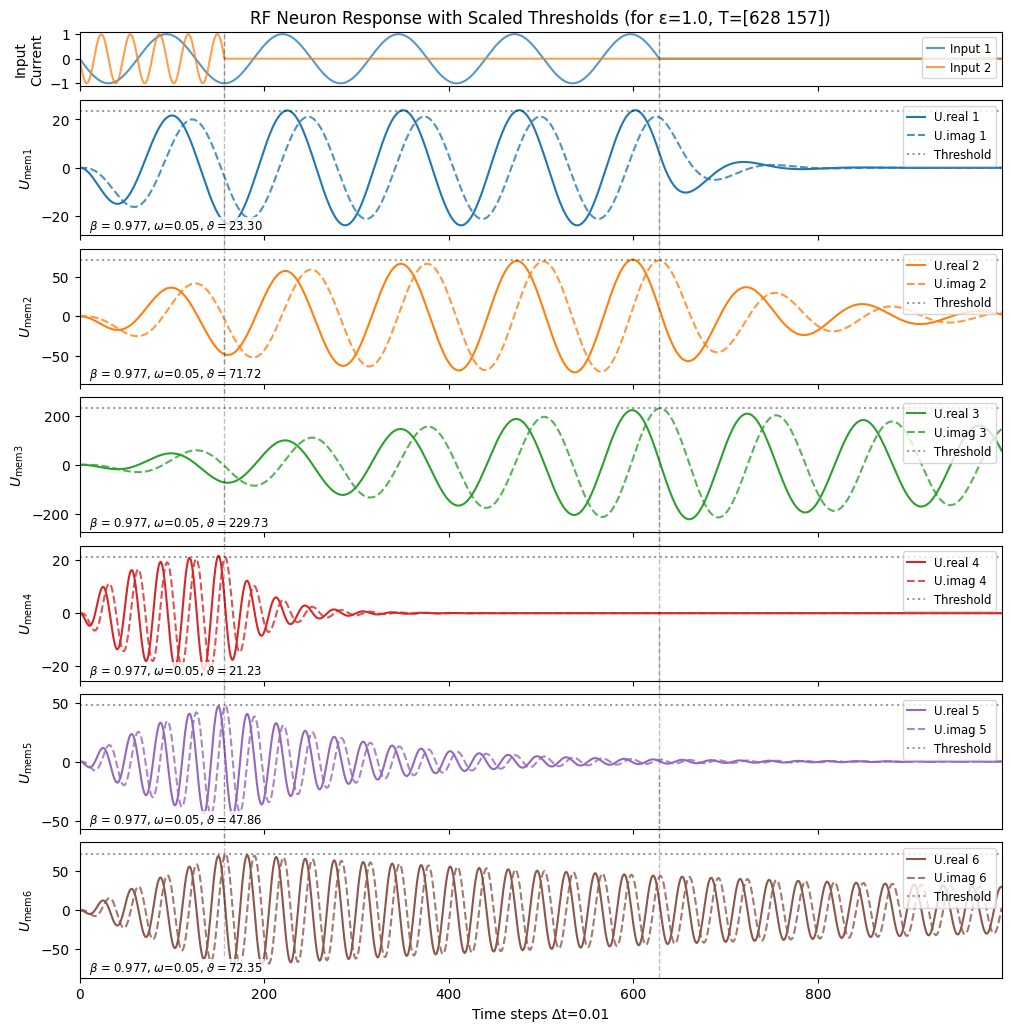

In [249]:
num_steps = NUM_STEPS * 2
omegas = np.array([5, 20])*DT
rhos = np.exp(1j * omegas)
betas = np.array([0.1, 0.5, 0.9])**DT
bs = -np.log(betas)

# Create resonant input signal
amp_in = 1
cur_in_slow = -np.sin(omegas[0] * np.arange(num_steps)) * amp_in
cur_in_fast = -np.sin(omegas[1] * np.arange(num_steps)) * amp_in

# Calculate A_max according to the derived formula
A_max_slow = (amp_in * np.sqrt(bs**2 + omegas[0]**2)) / (bs * np.sqrt(bs**2 + 4*omegas[0]**2))
A_max_fast = (amp_in * np.sqrt(bs**2 + omegas[1]**2)) / (bs * np.sqrt(bs**2 + 4*omegas[1]**2))

n_oscillations = 5
T_steps = ((2 * np.pi * n_oscillations) / omegas).astype(int)
# T_steps = 50 # Alternatively, set a fixed number of steps
eps = 1.
thr_slow = eps * A_max_slow * (1 - betas**T_steps[0])
thr_fast = eps * A_max_fast * (1 - betas**T_steps[1])
thrs = np.array([thr_slow, thr_fast]).flatten()

# Turn off input after n_oscillations
cur_in_slow[T_steps[0]+1:] = 0
cur_in_fast[T_steps[1]+1:] = 0

# Simulate
mem_vars = np.full((len(omegas)*len(betas)), 0+0j)
spk_vars = np.full((len(omegas)*len(betas)), False)
mem_recs = np.zeros((len(omegas)*len(betas), num_steps), dtype=complex)
spk_recs = np.zeros((len(omegas)*len(betas), num_steps), dtype=bool)
for i, (rho, cur_in, thr) in enumerate(zip(rhos, [cur_in_slow, cur_in_fast], [thr_slow, thr_fast])):
    m, n = i*len(betas), (i+1)*len(betas)
    for step in range(num_steps):
        mem_recs[m:n, step], spk_recs[m:n, step] = mem_vars[m:n], spk_vars[m:n]
        spk_vars[m:n], mem_vars[m:n] = resonate_and_fire(mem_vars[m:n], betas, rho, I=cur_in[step], threshold=thr)

# Plot the results
snn_plot(cur_in=[cur_in_slow, cur_in_fast], mem=mem_recs, ylim=thrs*1.2/eps, hline=thrs,
         vline=T_steps, dt=DT, 
         mem_labels=[f'$\\beta$ = {beta:.3f}, $\\omega$={omega:.2f}, $\\vartheta={thr:.2f}$' for omega in omegas for beta in betas for thr in thrs],
         title=f"RF Neuron Response with Scaled Thresholds (for ε={eps}, T={T_steps})")

# Conclusion: the Simplified Resonate-and-Fire Neuron
The update rule for our Simplified Resonate-and-Fire (SRF) neuron model that we have derived and implemented is as follows:

$$ \begin{align*}
U[t + 1] &= \beta \cdot \rho \cdot U[t] + \underbrace{W X[t + 1]}_{\text{input}} - \underbrace{S[t]R(U[t])}_{\text{reset}}, \tag{11} \\
\text{with init. } \beta &= \beta_{\rm cont}^{\Delta t} \text{ (decay)},\quad \rho = e^{i\omega \Delta t} \text{ (rotation)}
\end{align*} $$

Initial experiments have shown that the resonating dynamics are produced faithfully by the model, capturing essential features while being computationally efficient and more easily initialised.

The next steps will involve implementing refractory mechanisms, and integrating the SRF neuron model into fully-fledged SNNs and exploring its training capabilities and viability for practical applications.  
We aim to establish a foundation for resonator-type neurons, and hope to introduce SRF neurons to established SNN frameworks eventually.

## Further Reading
* [*Training Spiking Neural Networks Using Lessons From Deep Learning* (2023)](https://ieeexplore.ieee.org/document/10242251#full-text-header) by Eshraghian et al.